In [1]:
import os
import urllib
import pandas as pd
import numpy as np
from numpy.random import uniform, binomial
from sklearn.model_selection import KFold
import math
import matplotlib.pyplot as plt
import time

import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
import tensorflow_addons as tfa
from tensorflow import keras
from tensorflow.keras import layers

import tensorflow_probability as tfp
tfd = tfp.distributions

# To remove WARNINGS from saving the models without compiling them first
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

#print(tf.__version__)
#print(tf.test.gpu_device_name())

In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print(tf.config.list_physical_devices())

#Working with CPU for now...

Num GPUs Available:  0
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


In [3]:
from __future__ import division
import datetime
import os
import numpy as np
import pandas as pd
from collections import defaultdict
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from random import seed
#from .UCI_loader import unnormalise_cat_vars


# TODO return mean and std for variables + train test split

"""
def check_data_file(fname):
    files = os.listdir(".")  # get the current directory listing
    print
    "Looking for file '%s' in the current directory..." % fname

    if fname not in files:
        print
        "'%s' not found! Downloading from GitHub..." % fname
        addr = "https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores-two-years.csv"
        try:
            response = urllib2.urlopen(addr)
        except:
            response = urllib3.urlopen(addr)
        data = response.read()
        fileOut = open(fname, "w")
        fileOut.write(data)
        fileOut.close()
        print
        "'%s' download and saved locally.." % fname
    else:
        print
        "File found in current directory.."
"""

def check_data_file(fname):
    files = os.listdir(".")  # get the current directory listing
    print
    "Looking for file '%s' in the current directory..." % fname

    if fname not in files:
        print
        "'%s' not found! Downloading from GitHub..." % fname
        addr = "https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores-two-years.csv"
        
        response = urllib.request.urlopen(addr)

        data = response.read()
        fileOut = open(fname, "wb")
        fileOut.write(data)
        fileOut.close()
        print
        "'%s' download and saved locally.." % fname
    else:
        print
        "File found in current directory.."

def get_my_COMPAS(rseed=0, separate_test=True, test_ratio=0.2, save_dir='../data/'):
    """
        The adult dataset can be obtained from: https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores-two-years.csv
        The code will look for the data file in the present directory, if it is not found, it will download them from GitHub.
    """

    SEED = rseed
    seed(SEED)
    np.random.seed(SEED)

    their_FEATURES_CLASSIFICATION = ["age_cat", "race", "sex", "priors_count", "c_charge_degree"]
    FEATURES_CLASSIFICATION = ["age_cat", "race", "sex", "c_charge_degree", "is_recid", "priors_count",
                               "time_served"]  # features to be used for classification
    CONT_VARIABLES = ["priors_count",
                      "time_served"]  # continuous features, will need to be handled separately from categorical features, categorical features will be encoded using one-hot
    CLASS_FEATURE = "two_year_recid"  # the decision variable


    COMPAS_INPUT_FILE = save_dir + "compas-scores-two-years.csv"
    check_data_file(COMPAS_INPUT_FILE)

    # load the data and get some stats
    df = pd.read_csv(COMPAS_INPUT_FILE)
    df = df.dropna(subset=["days_b_screening_arrest"])  # dropping missing vals

    # convert to np array
    data = df.to_dict('list')
    for k in data.keys():
        data[k] = np.array(data[k])

    dates_in = data['c_jail_in']
    dates_out = data['c_jail_out']
    # this measures time in Jail
    time_served = []
    for i in range(len(dates_in)):
        di = datetime.datetime.strptime(dates_in[i], '%Y-%m-%d %H:%M:%S')
        do = datetime.datetime.strptime(dates_out[i], '%Y-%m-%d %H:%M:%S')
        time_served.append((do - di).days)
    time_served = np.array(time_served)
    time_served[time_served < 0] = 0
    data["time_served"] = time_served

    """ Filtering the data """

    # These filters are the same as propublica (refer to https://github.com/propublica/compas-analysis)
    # If the charge date of a defendants Compas scored crime was not within 30 days from when the person was arrested, we assume that because of data quality reasons, that we do not have the right offense.
    idx = np.logical_and(data["days_b_screening_arrest"] <= 30, data["days_b_screening_arrest"] >= -30)

    # We coded the recidivist flag -- is_recid -- to be -1 if we could not find a compas case at all.
    idx = np.logical_and(idx, data["is_recid"] != -1)

    # In a similar vein, ordinary traffic offenses -- those with a c_charge_degree of 'O' -- will not result in Jail time are removed (only two of them).
    idx = np.logical_and(idx, data["c_charge_degree"] != "O")  # F: felony, M: misconduct

    # We filtered the underlying data from Broward county to include only those rows representing people who had either recidivated in two years, or had at least two years outside of a correctional facility.
    idx = np.logical_and(idx, data["score_text"] != "NA")

    # select the examples that satisfy this criteria
    for k in data.keys():
        data[k] = data[k][idx]

    y = data[CLASS_FEATURE]
    """ Feature normalization and one hot encoding """

    print
    "\nNumber of people recidivating within two years"
    print
    pd.Series(y).value_counts()
    print
    "\n"

    X = []  # empty array with num rows same as num examples, will hstack the features to it
    X_dims = []

    feature_names = []
    for attr in FEATURES_CLASSIFICATION:
        vals = data[attr]
        if attr in CONT_VARIABLES:
            vals = [float(v) for v in vals]
            # vals = preprocessing.scale(vals, axis=0, with_mean=True, with_std=True)  # 0 mean and 1 variance
            vals = np.reshape(vals, (len(y), -1))  # convert from 1-d arr to a 2-d arr with one col
            X_dims.append(1)

        else:  # for binary categorical variables, the label binarizer uses just one var instead of two
            enc = preprocessing.OneHotEncoder(categories='auto', handle_unknown='error')
            enc.fit(vals.reshape(-1, 1))
            vals = enc.transform(vals.reshape(-1, 1)).todense()
            X_dims += [vals.shape[1]]*vals.shape[1]

        # add to learnable features
        X.append(vals)

        if attr in CONT_VARIABLES:  # continuous feature, just append the name
            feature_names.append(attr)
        else:  # categorical features
            if vals.shape[1] == 1:  # binary features that passed through lib binarizer
                feature_names.append(attr)
            else:
                for k in enc.categories_:  # non-binary categorical features, need to add the names for each cat
                    feature_names.append(attr + "_" + str(k))

    X = np.array(np.concatenate(list(X), axis=1))
    X_dims = np.array(X_dims)

    if separate_test:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_ratio, random_state=rseed, shuffle=True)

        x_means, x_stds = X_train.mean(axis=0), X_train.std(axis=0)
        x_means[X_dims>1] = 0
        x_stds[X_dims>1] = 1
        x_stds[x_stds < 1e-10] = 1

        x_train = ((X_train - x_means) / x_stds).astype(np.float32)
        x_test = ((X_test - x_means) / x_stds).astype(np.float32)

        return x_train, x_test, x_means, x_stds, y_train, y_test, feature_names, X_dims
    else:
        x_means, x_stds = X.mean(axis=0), X.std(axis=0)
        x_means[:,X_dims>1] = 0
        x_stds[:,X_dims>1] = 1
        x_stds[x_stds < 1e-10] = 1

        x_train = ((X - x_means) / x_stds).astype(np.float32)

        return x_train, x_means, x_stds, y, feature_names, X_dims

def join_compas_targets(x_train, x_test, y_train, y_test, X_dims):
    # output from get method is onehot so we need to flatten and append 2
    input_dim_vec = X_dims_to_input_dim_vec(X_dims)
    input_dim_vec = np.append(input_dim_vec, 2)
    enc = preprocessing.OneHotEncoder(categories='auto', handle_unknown='error')
    enc.fit(y_train.reshape(-1, 1))

    vals_train = np.array(enc.transform(y_train.reshape(-1, 1)).todense()).astype(np.float32)
    vals_test = np.array(enc.transform(y_test.reshape(-1, 1)).todense()).astype(np.float32)

    x_train = np.concatenate([x_train, vals_train], axis=1)
    x_test = np.concatenate([x_test, vals_test], axis=1)
    return x_train, x_test, input_dim_vec

def X_dims_to_input_dim_vec(X_dims):
    """This is for our cat_Gauss VAE model"""
    input_dim_vec = []
    i = 0
    while i < len(X_dims):
        input_dim_vec.append(X_dims[i])
        i += X_dims[i]
    return np.array(input_dim_vec)

#"""
def input_dim_vec_to_X_dims(input_dim_vec):
    # This is for our cat_Gauss VAE model
    X_dims = []
    for i in input_dim_vec:
        for ii in range(i):
            X_dims.append(i)
    return np.array(X_dims)
#"""

## Reading data

In [4]:
# For Default credit

input_dim_vec = [1, 2, 4, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1 ,1 ,1 ,1 ,1 ,1, 2]
width = 350
depth = 3
latent_dim = 8

# For all tabular data sets
names = ['wine', 'default_credit', 'compas', 'lsat']
widths = [350, 350, 350, 350] # Bigger than VAE because the task of modelling all conditionals is more complex
depths = [3, 3, 3, 3] # We go deeper because we are using residual models
latent_dims = [6, 8, 4, 4]
under_latent_dims = [6, 8, 4, 4] # following the original paper we set dim(u) = dim(z) with d>r [r is true manifold dim]
under_latent_dims2 = [4, 6, 3, 3] # following the original paper we set dim(u) = dim(z) with d>r [r is true manifold dim]

dname = 'default_credit'
print(dname)


default_credit


In [5]:
# Load the datasets in UCI
def load_UCI(dset_name, splits=10, seed=0, separate_targets=True, save_dir='data/'):
    mkdir(save_dir)

    if dset_name == 'wine':
        if not os.path.isfile(save_dir+'winequality-red.csv'):
            urllib.request.urlretrieve("https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv",
                               filename=save_dir+'winequality-red.csv')
        data = pd.read_csv(save_dir+'winequality-red.csv', header=1, delimiter=';').values
        y_idx = [-1]

    elif dset_name == 'default_credit':
        if not os.path.isfile(save_dir + 'default of credit card clients.xls'):
            urllib.request.urlretrieve(
                "https://archive.ics.uci.edu/ml/machine-learning-databases/00350/default%20of%20credit%20card%20clients.xls",
                filename=save_dir + 'default of credit card clients.xls')
        data = pd.read_excel(save_dir + 'default of credit card clients.xls', header=[0, 1], index_col=0, # delimiter="\s+"
                             ).values
        y_idx = [-1]  # OK


    else:
        raise Exception('Dataset name doesnt match any known datasets.')

    np.random.seed(seed)
    data = data[np.random.permutation(np.arange(len(data)))] #Shuffle the data
    
    kf = KFold(n_splits=splits)
    for j, (train_index, test_index) in enumerate(kf.split(data)):

        # Not sure what separate targets is
        if separate_targets:
            x_idx = list(range(data.shape[1]))
            for e in y_idx:
                x_idx.remove(x_idx[e])

            x_idx = np.array(x_idx)
            y_idx = np.array(y_idx)
            x_train, y_train = data[train_index, :], data[train_index, :]
            x_train, y_train = x_train[:, x_idx], y_train[:, y_idx]
            x_test, y_test = data[test_index, :], data[test_index, :]
            x_test, y_test = x_test[:, x_idx], y_test[:, y_idx]

            x_means, x_stds = x_train.mean(axis=0), x_train.std(axis=0)
            y_means, y_stds = y_train.mean(axis=0), y_train.std(axis=0)

            y_stds[y_stds < 1e-10] = 1
            x_stds[x_stds < 1e-10] = 1

            x_train = ((x_train - x_means) / x_stds).astype(np.float32)
            y_train = ((y_train - y_means) / y_stds).astype(np.float32)

            x_test = ((x_test - x_means) / x_stds).astype(np.float32)
            y_test = ((y_test - y_means) / y_stds).astype(np.float32)

            return x_train, x_test, x_means, x_stds, y_train, y_test, y_means, y_stds

        else:
            x_train, x_test = data[train_index, :], data[test_index, :]
            x_means, x_stds = x_train.mean(axis=0), x_train.std(axis=0)

            x_stds[x_stds < 1e-10] = 1

            x_train = ((x_train - x_means) / x_stds).astype(np.float32)
            x_test = ((x_test - x_means) / x_stds).astype(np.float32)

            return x_train, x_test, x_means, x_stds

def mkdir(paths):
    if not isinstance(paths, (list, tuple)):
        paths = [paths]
    for path in paths:
        if not os.path.isdir(path):
            os.makedirs(path, mode=0o777)

def unnormalise_cat_vars(x, x_means, x_stds, input_dim_vec):
    """
    Converts a feature vector with continous values into a vector with continous and discrete values for those 
    which come from a categorical class.
    """
    input_dim_vec = np.array(input_dim_vec)
    unnorm_x = np.multiply(x, x_stds) + x_means

    fixed_unnorm = unnorm_x.round()
    fixed_unnorm -= fixed_unnorm.min(axis=0).reshape([1, fixed_unnorm.shape[1]])  # this sets all mins to 0
    for idx, dims in enumerate(input_dim_vec):
        if dims > 1:
            vec = fixed_unnorm[:, idx]
            vec[vec > dims - 1] = dims - 1
            fixed_unnorm[:, idx] = vec

    x[:, input_dim_vec > 1] = fixed_unnorm[:, input_dim_vec > 1]
    return x


## Recognition (Encoder)

In [6]:
"""
The arguments sent to the different keras layers are there to mimic the Torch layers in CLUE.
"""

def create_recognition_encoder(width, depth, latent_dim, input_dim_vec):
    # Tensorflow network as one big Russian doll
    nb_inputs = sum(input_dim_vec)
    inputs = keras.Input(shape=(nb_inputs,))
    #inputs = keras.Input(shape=(None,nb_inputs))
    input = layers.Dense(width, use_bias=True, \
                         kernel_initializer = tf.keras.initializers.RandomUniform(-math.sqrt(1/nb_inputs), math.sqrt(1/nb_inputs)), \
                         bias_initializer = tf.keras.initializers.RandomUniform(-math.sqrt(1/nb_inputs), math.sqrt(1/nb_inputs))) \
                         (inputs)

    for i in range(depth-1):

        x = layers.LeakyReLU(alpha=0.01)(input)
        x = layers.BatchNormalization(momentum=0.1, epsilon=1e-5)(x)
        x = layers.Dense(width, use_bias=True, \
                         kernel_initializer = tf.keras.initializers.RandomUniform(-math.sqrt(1/width), math.sqrt(1/width)), \
                         bias_initializer = tf.keras.initializers.RandomUniform(-math.sqrt(1/width), math.sqrt(1/width))) \
                         (x)

        # Skip connection 
        x = x + input

        input = x

    # Final layers
    x = layers.LeakyReLU(alpha=0.01)(x)
    x = layers.BatchNormalization(momentum=0.1, epsilon=1e-5)(x)
    outputs = layers.Dense(latent_dim*2, use_bias=True, \
                         kernel_initializer = tf.keras.initializers.RandomUniform(-math.sqrt(1/width), math.sqrt(1/width)), \
                         bias_initializer = tf.keras.initializers.RandomUniform(-math.sqrt(1/width), math.sqrt(1/width))) \
                         (x)

    recognition_encoder = keras.Model(inputs=inputs, outputs=outputs, name="recognition_encoder_model")
    return recognition_encoder
#recognition_encoder.summary()

#keras.utils.plot_model(encoder, "encoder.png")
#keras.utils.plot_model(recognition_encoder, "recognition.png", show_shapes=True)


## Prior network (Encoder)

In [7]:
"""
The arguments sent to the different keras layers are there to mimic the Torch layers in CLUE.
"""

def create_prior_encoder(width, depth, latent_dim, input_dim_vec):
    nb_inputs = sum(input_dim_vec)*2
    inputs = keras.Input(shape=(nb_inputs,))
    #inputs = keras.Input(shape=(None,nb_inputs))
    input = layers.Dense(width, use_bias=True, \
                         kernel_initializer = tf.keras.initializers.RandomUniform(-math.sqrt(1/nb_inputs), math.sqrt(1/nb_inputs)), \
                         bias_initializer = tf.keras.initializers.RandomUniform(-math.sqrt(1/nb_inputs), math.sqrt(1/nb_inputs))) \
                         (inputs)

    for i in range(depth-1):

        x = layers.LeakyReLU(alpha=0.01)(input)
        x = layers.BatchNormalization(momentum=0.1, epsilon=1e-5)(x)
        x = layers.Dense(width, use_bias=True, \
                         kernel_initializer = tf.keras.initializers.RandomUniform(-math.sqrt(1/width), math.sqrt(1/width)), \
                         bias_initializer = tf.keras.initializers.RandomUniform(-math.sqrt(1/width), math.sqrt(1/width))) \
                         (x)

        x = x + input

        input = x

    x = layers.LeakyReLU(alpha=0.01)(x)
    x = layers.BatchNormalization(momentum=0.1, epsilon=1e-5)(x)
    outputs = layers.Dense(latent_dim*2, use_bias=True, \
                         kernel_initializer = tf.keras.initializers.RandomUniform(-math.sqrt(1/width), math.sqrt(1/width)), \
                         bias_initializer = tf.keras.initializers.RandomUniform(-math.sqrt(1/width), math.sqrt(1/width))) \
                         (x)

    prior_encoder = keras.Model(inputs=inputs, outputs=outputs, name="prior_encoder_model")
    return prior_encoder
#prior_encoder.summary()

#keras.utils.plot_model(encoder, "encoder.png")
#keras.utils.plot_model(prior_encoder, "prior.png", show_shapes=True)

## Generator (Decoder)

In [8]:
"""
The arguments sent to the different keras layers are there to mimic the Torch layers in CLUE.
"""

def create_decoder(width, depth, latent_dim, input_dim_vec):
    nb_inputs = latent_dim
    inputs = keras.Input(shape=(nb_inputs,))
    input = layers.Dense(width, use_bias=True, \
                         kernel_initializer = tf.keras.initializers.RandomUniform(-math.sqrt(1/nb_inputs), math.sqrt(1/nb_inputs)), \
                         bias_initializer = tf.keras.initializers.RandomUniform(-math.sqrt(1/nb_inputs), math.sqrt(1/nb_inputs))) \
                         (inputs)

    for i in range(depth-1):

        x = layers.LeakyReLU(alpha=0.01)(input)
        x = layers.BatchNormalization(momentum=0.1, epsilon=1e-5)(x)
        x = layers.Dense(width, use_bias=True, \
                         kernel_initializer = tf.keras.initializers.RandomUniform(-math.sqrt(1/width), math.sqrt(1/width)), \
                         bias_initializer = tf.keras.initializers.RandomUniform(-math.sqrt(1/width), math.sqrt(1/width))) \
                         (x)
        x = x + input

        input = x

    x = layers.LeakyReLU(alpha=0.01)(x)
    x = layers.BatchNormalization(momentum=0.1, epsilon=1e-5)(x)
    outputs = layers.Dense(sum(input_dim_vec), use_bias=True, \
                         kernel_initializer = tf.keras.initializers.RandomUniform(-math.sqrt(1/width), math.sqrt(1/width)), \
                         bias_initializer = tf.keras.initializers.RandomUniform(-math.sqrt(1/width), math.sqrt(1/width))) \
                         (x)

    decoder = keras.Model(inputs=inputs, outputs=outputs, name="decoder_model")
    return decoder

#decoder.summary()

#keras.utils.plot_model(model, "decoder_model.png")
#keras.utils.plot_model(decoder, "generator.png", show_shapes=True)


## Masker

In [9]:
class top_masker_tensorflow:
    """
    Returned mask is sampled from component-wise independent Bernoulli
    distribution with probability of component to be unobserved p.
    Such mask induces the type of missingness which is called
    in literature "missing completely at random" (MCAR).
    If some value in batch is missed, it automatically becomes unobserved.
    """
    def __init__(self, p):
        self.p = p

    def __call__(self, batch):
        """
        Parameters:
            - batch is a numpy array with as many rows as batch_size and as many columns as features
        
        Returned:
       
            - mask is a float32 tensor
        
        The mask seems to be random
        """
        # Generate one uniform number for each row (1xrow numpy matrix)
        pp = uniform(low=0.0, high=self.p, size=batch.shape[0]) 
        pp = np.expand_dims(pp, axis=1) # Put the number in 1x1 matrices in a 1x#row matrix
        pp = np.repeat(pp, batch.shape[1], axis=1) # Repeat the number across each row
        nan_mask = tf.math.is_nan(batch) # If nan => should be unobserved i.e. boolean True
        
        # Generate Bernoulli samples (0 or 1) from pp i.e. for each sample in batch determine if a feature is
        # observed or hidden.
        bernoulli_mask_numpy = binomial(1, pp, size=None) 
        bernoulli_mask = tf.convert_to_tensor(tf.cast(bernoulli_mask_numpy, tf.bool))
        mask = tf.math.logical_or(bernoulli_mask, nan_mask) # Logical or between bernoulli and nan mask
        
        # Logical not to invert the mask (This is done in CLUE)
        # Mask is converted to a boolean tensor with floats for element wise multiplication with the batch
        # which is done in apply mask
        # (True => 0, False => 1)
        
        # TODO: The logical_not might be unnecessary as the probability of getting a true or false is equal.
        #      To mirror the Torch code however I did this but it can perhaps be removed later...
        
        return tf.cast(tf.math.logical_not(mask), dtype=tf.float32)
        #return tf.cast(mask, dtype=tf.float32)

## Utils

In [10]:
def gauss_cat_to_flat_mask(mask, input_dim_vec):
    output = []
    for idx, dim in enumerate(input_dim_vec):
        if dim == 1:
            """
            tf.expand_dims (axis=1) takes mask[:, idx] (batch_size,) and 
            converts it into (64,1) e.g. [1,2,3] => [[1];[2];[3]] i.e. same as torch unsqueeze(1)
            """
            output.append(tf.expand_dims(mask[:, idx], axis=1))

        elif dim > 1: 
            """
            tf.expand_dims (read comment above)
            tf.ones([mask.shape[0], dim]) creates an array of batch_size x dim with ones
            oh_vec will be mask.shape[0] x dim and contain 0 or 1 on rows depending on if mask is 0 or 1.
            """
            oh_vec = tf.ones([mask.shape[0], dim]) * tf.expand_dims(mask[:, idx], axis=1)

            output.append(oh_vec)
        else:
            raise ValueError('Error, invalid dimension value')
    return tf.concat(output, axis=1)

def gauss_cat_to_flat(x, input_dim_vec):
    """
    Parameters:
        - x: numpy array
        - input_dim_vec: list e.g. [1, 2, 4, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1 ,1 ,1 ,1 ,1 ,1, 2] credit
    Returns:
        - numpy array 
        
    Example:
        
        x:
             [-0.52121574  0.          2.          1.          1.2496392   0.01383046
              0.1105278   1.8173771   0.18815508  0.2341654   1.9953084   0.2038664
              0.31341553  0.31455126  0.32473356  0.4501966   0.45570025  0.0774322
             -0.2517514  -0.1535475   0.03951775 -0.31174627 -0.12532774  0.        ]
        
        input_dim_vec:
            [1, 2, 4, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1 ,1 ,1 ,1 ,1 ,1, 2]
        
        return:
             [-0.52121574  1.          0.          0.          0.          1.
              0.          0.          1.          0.          1.2496392   0.01383046
              0.1105278   1.8173771   0.18815508  0.2341654   1.9953084   0.2038664
              0.31341553  0.31455126  0.32473356  0.4501966   0.45570025  0.0774322
             -0.2517514  -0.1535475   0.03951775 -0.31174627 -0.12532774  1.
              0.        ]
    """
    output = []
    for idx, dim in enumerate(input_dim_vec):
        if dim == 1:
            output.append(tf.expand_dims(x[:, idx], axis=1))
        elif dim > 1:
            oh_vec = tf.one_hot(x[:, idx], dim) # Returns one hot encoding 0 with dim 2 -> 1 0, 1 -> 0 1
            output.append(oh_vec)
        else:
            raise ValueError('Error, invalid dimension value')
    return tf.concat(output, axis=1).numpy()


## CLASS VAEAC and loss and training

In [11]:
class VAEAC_gauss_cat(tf.keras.Model):
    def __init__(self, width, depth, latent_dim, input_dim_vec, batch_size, lr, optimizer, save_model):
        super(VAEAC_gauss_cat, self).__init__()
        self.latent_dim = latent_dim
        self.input_dim_vec = input_dim_vec
        self.recognition_encoder = create_recognition_encoder(width, depth, latent_dim, input_dim_vec)
        self.prior_encoder = create_prior_encoder(width, depth, latent_dim, input_dim_vec)
        self.decoder = create_decoder(width, depth, latent_dim, input_dim_vec)
        self.sigma_mu = 1e4
        self.sigma_sigma = 1e-4
        self.vlb_scale = 1 / len(self.input_dim_vec)
        self.batch_size = batch_size
        self.optimizer = optimizer
        self.save_model = save_model
        self.lr = lr

    # Inspiration taken from 
    # https://github.com/joocxi/tf2-VAEAC/blob/d2b1bbc258ec77ee0975ea7eb68e63c4efcda6f0/model/vaeac.py
    def prior_regularizer(self, prior):

        mu = tf.reshape(prior.mean(), (self.batch_size, -1))
        sigma = tf.reshape(prior.scale, (self.batch_size, -1))

        mu_regularizer = -tf.reduce_sum(tf.square(mu), -1) / (2 * self.sigma_mu ** 2)
        sigma_regularizer = tf.reduce_sum((tf.math.log(sigma) - sigma), -1) * self.sigma_sigma
        return mu_regularizer + sigma_regularizer

    def apply_mask(self, x, mask):
        return x * mask

    def reconstruction_loss(self, x, y):
        log_prob_vec = []
        
        cum_dims = 0
        reshape_dim = self.batch_size
        for idx, dims in enumerate(self.input_dim_vec):
            if dims == 1:
                # Gaussian_case
                log_prob_vec.append(tf.expand_dims(-(x[:, cum_dims] - y[:, cum_dims])**2, 1))
                
                cum_dims += 1

            elif dims > 1:
                # if x.shape[1] == y.shape[1]:
                #    raise Exception('Input and target seem to be in flat format. Need integer cat targets.'

                cce = tf.keras.losses.CategoricalCrossentropy(reduction=tf.keras.losses.Reduction.NONE, from_logits = True)
                cat_cross_entropy = -cce(tf.cast(y[:, cum_dims:cum_dims + dims], dtype=tf.int64), x[:, cum_dims:cum_dims + dims])
                #cat_cross_entropy = -tf.nn.softmax_cross_entropy_with_logits(labels=tf.cast(y[:, cum_dims:cum_dims + dims], dtype=tf.int64), logits=x[:, cum_dims:cum_dims + dims])
                log_prob_vec.append(tf.expand_dims(cat_cross_entropy, 1))
                cum_dims += dims
                
            else:
                raise ValueError('Error, invalid dimension value')
        
        log_prob_vec = tf.reshape(log_prob_vec, [reshape_dim, len(self.input_dim_vec)])
        log_prob_vec = tf.reduce_sum(log_prob_vec, axis= -1)     # Do I want this? 
                                                                 # Yes vlb in original code does this when return
        return log_prob_vec

def eval(model, x_batch, x_flat, x_masked, mask):

    x_flat = tf.convert_to_tensor(x_flat)

    prior_params = model.prior_encoder(x_masked)
    #prior_params = model.prior_encoder(x_masked, training = True)
    #prior_params = model.prior_encoder(x_masked, training = False)

    proposal_params = model.recognition_encoder(x_flat)
    #proposal_params = model.recognition_encoder(x_flat, training = True)
    #proposal_params = model.recognition_encoder(x_flat, training = False)

    # Essentially CLUEs normal_parse_params
    prior_distribution = tfd.Normal(
      loc=prior_params[..., :model.latent_dim],
      scale=tf.clip_by_value(
        tf.nn.softplus(prior_params[..., model.latent_dim:]),
        1e-3,
        tf.float32.max),
      name="priors")

    proposal_distribution = tfd.Normal(
      loc=proposal_params[..., :model.latent_dim],
      scale=tf.clip_by_value(
        tf.nn.softplus(proposal_params[..., model.latent_dim:]),
        1e-3,
        tf.float32.max),
      name="proposal")

    z_sample = proposal_distribution.loc

    rec_params = model.decoder(z_sample)
    #rec_params = model.decoder(z_sample, training = True)
    #rec_params = model.decoder(z_sample, training = False)
    
    regularizer = model.prior_regularizer(prior_distribution)

    rec_loss = model.reconstruction_loss(rec_params, x_flat)

    # True distribution, Estimated distribution in this order
    kl_divergence = tf.reduce_sum(
      tf.reshape(
        tfd.kl_divergence(proposal_distribution, prior_distribution),
        (model.batch_size, -1)), -1)

    vlb = tf.reduce_mean(-kl_divergence + rec_loss + regularizer) # For comparing
    return vlb, kl_divergence, rec_loss, regularizer

def compute_loss_VAEAC(model, x_batch, x_flat, x_masked, mask):
    
    prior_params = model.prior_encoder(x_masked) 
    proposal_params = model.recognition_encoder(x_flat)
    #prior_params = model.prior_encoder(x_masked, training = True) 
    #proposal_params = model.recognition_encoder(x_flat, training = True)
    #prior_params = model.prior_encoder(x_masked, training = False) 
    #proposal_params = model.recognition_encoder(x_flat, training = False)

    # Essentially CLUEs normal_parse_params
    proposal_distribution = tfd.Normal(
      loc=proposal_params[..., :model.latent_dim],
      scale=tf.clip_by_value(
        tf.nn.softplus(proposal_params[..., model.latent_dim:]),
        1e-3,
        tf.float32.max),
      name="proposal")

    prior_distribution = tfd.Normal(
      loc=prior_params[..., :model.latent_dim],
      scale=tf.clip_by_value(
        tf.nn.softplus(prior_params[..., model.latent_dim:]),
        1e-3,
        tf.float32.max),
      name="priors")

    regularizer = model.prior_regularizer(prior_distribution)

    latent = proposal_distribution.sample()

    generative_params = model.decoder(latent)
    #generative_params = model.decoder(latent, training = True)
    #generative_params = model.decoder(latent, training = False)
    
    rec_loss = model.reconstruction_loss(generative_params, x_flat)
    
    # True distribution, Estimated distribution in this order
    kl_divergence = tf.reduce_sum(
      tf.reshape(
        tfd.kl_divergence(proposal_distribution, prior_distribution),
        (model.batch_size, -1)), -1)

    vlb = tf.reduce_mean(-kl_divergence + rec_loss + regularizer) # For comparing
    loss = tf.reduce_mean((kl_divergence - rec_loss - regularizer) * model.vlb_scale) 
    return loss, vlb, kl_divergence, rec_loss, regularizer

@tf.function # Converts all numpy arrays to tensors
def train_step_VAEAC(model, x_batch, x_flat, x_masked, mask):

    with tf.GradientTape() as tape:
        loss, vlb, kl_divergence, rec_loss, regularizer = compute_loss_VAEAC(model, x_batch, x_flat, x_masked, mask)
    
    gradients = tape.gradient(loss, model.trainable_variables)
    model.optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    return loss, vlb, kl_divergence, rec_loss, regularizer



In [12]:
def batch(iterable, n=1):
    l = len(iterable)
    for ndx in range(0, l, n):
        yield iterable[ndx:min(ndx + n, l)]

def train_VAEAC(model, x_train, x_test, masker, nb_epochs, early_stop = None, flatten=False):
    
    vlb_train = np.zeros(nb_epochs)
    vlb_val = np.zeros(nb_epochs)
    best_vlb = -np.inf
    best_epoch = 0
    
    overall_batch_size = model.batch_size
    
    test_data = []
    for x in batch(x_test, n = overall_batch_size):
        test_data.append(x)
    
    epoch = 0
    for epoch in range(0, nb_epochs):
        
        # Shuffle the training data and sort it into batches every epoch
        train_data = []
        np.random.shuffle(x_train)
        for x in batch(x_train, n = overall_batch_size):
            train_data.append(x)
        
        tic = time.time()

        ## Training
        nb_samples = 0
        
        for x_batch in train_data:

            model.batch_size = x_batch.shape[0] # TODO: FIX THIS: Very ugly solution now to make sure batches 
                                                # that do not have the full size
                
            mask = masker(x_batch) #tensor with floats
            
            # If data is not already flattened (default credit)
            if flatten:
                x_batch_flat = gauss_cat_to_flat(x_batch, model.input_dim_vec) # numpy
                mask_flat = gauss_cat_to_flat_mask(mask, model.input_dim_vec)
            
            # If data is already flattened (COMPAS from join_compas_targets)
            else:
                x_batch_flat = x_batch
                mask_flat = mask

            # Mask flattened batch
            x_batch_flat_masked = model.apply_mask(tf.convert_to_tensor(x_batch_flat), mask_flat)
            
            # Concat the mask flattened batch with the flattened mask
            x_batch_flat_masked_concat = tf.concat([x_batch_flat_masked, mask_flat], axis=1)
            
            loss, vlb, kl_divergence, rec_loss, regularizer = train_step_VAEAC(model, x_batch, x_batch_flat, x_batch_flat_masked_concat, mask_flat)

            vlb_train[epoch] += vlb.numpy() * x_batch.shape[0]
            nb_samples += x_batch.shape[0]

        vlb_train[epoch] /= nb_samples
        toc = time.time()
        print("Epoch_" + str(epoch) + ", vlb: " + str(vlb_train[epoch]) + ", took: " + str(toc-tic))
        
        ## Validation
        nb_samples = 0
        for x_batch in test_data:
            model.batch_size = x_batch.shape[0] # TODO: FIX THIS: Very ugly solution now to make sure batches 
                                                # that do not have the full size

            mask = masker(x_batch) #tensor with floats
            
            # If data is not already flattened (default credit)
            if flatten:
                x_batch_flat = gauss_cat_to_flat(x_batch, model.input_dim_vec) # numpy
                mask_flat = gauss_cat_to_flat_mask(mask, model.input_dim_vec)
            
            # If data is already flattened (COMPAS from join_compas_targets)
            else:
                x_batch_flat = x_batch
                mask_flat = mask
            
            # Mask flattened batch
            x_batch_flat_masked = model.apply_mask(tf.convert_to_tensor(x_batch_flat), mask_flat)
            
            # Concat the mask flattened batch with the flattened mask
            x_batch_flat_masked_concat = tf.concat([x_batch_flat_masked, mask_flat], axis=1)
            
            vlb, kl_divergence, rec_loss, regularizer = eval(model, x_batch, x_batch_flat, x_batch_flat_masked_concat, mask_flat)

            vlb_val[epoch] += vlb.numpy() * x_batch.shape[0]
            nb_samples += x_batch.shape[0]

        vlb_val[epoch] /= nb_samples
    
        
        if vlb_val[epoch] > best_vlb:
            best_vlb = vlb_val[epoch]
            best_epoch = epoch
            if(model.save_model):
                
                folder = './tf_vaeac_vlb_plots/'
                #open text file
                text_file = open(str(dname) + "_best_epoch_VAEAC_lr_" + str(model.lr) + ".txt", "w")

                #write string to file
                text_file.write(str(epoch))

                #close file
                text_file.close()

                model.recognition_encoder.save(folder + str(dname) + "_recog_encoder_lr_" + str(model.lr))
                model.prior_encoder.save(folder + str(dname) + "_prior_encoder_lr_" + str(model.lr))
                model.decoder.save(folder + str(dname) + "_decoder_lr_" + str(model.lr))

        print("Validation vlb: " + str(vlb_val[epoch]) + ", Best vlb: " + str(best_vlb) + "\n")

        if early_stop is not None and (epoch - best_epoch) > early_stop:
            print("Early stopping triggered")
            break
    
    np.save(folder + str(dname) + "_vlb_train_lr_" + str(model.lr), vlb_train)
    np.save(folder + str(dname) + "_vlb_val_lr_" + str(model.lr), vlb_val)
    return vlb_train, vlb_val, best_epoch, best_vlb, epoch
        

## Train VAEAC (COMPAS)

In [13]:
masker = top_masker_tensorflow(p=1)

x_train, x_test, x_means, x_stds, y_train, y_test, feature_names, X_dims = \
    get_my_COMPAS(rseed=42, separate_test=True, test_ratio=0.1, save_dir='../data/')

x_train, x_test, input_dim_vec = join_compas_targets(x_train, x_test, y_train, y_test, X_dims)

print('Compas', x_train.shape, x_test.shape)
print(input_dim_vec)

dname = 'compas'
print(dname)

width = widths[names.index(dname)] # 350
depth = depths[names.index(dname)] # number of hidden layers # 3
latent_dim = latent_dims[names.index(dname)] # 4

batch_size = 128
nb_epochs = 2000
early_stop = 200
lr = 1e-4

optimizer = tfa.optimizers.RectifiedAdam(lr = lr, epsilon = 1e-8)

model = VAEAC_gauss_cat(width, depth, latent_dim, input_dim_vec, batch_size, lr, optimizer, save_model = True)

vlb_train, vlb_val, best_epoch, best_vlb, curr_epoch = train_VAEAC(model, x_train, x_test, masker, nb_epochs, early_stop=early_stop, flatten = False)



Compas (5554, 19) (618, 19)
[3 6 2 2 2 1 1 2]
compas


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/tensorflow_addons/optimizers/rectified_adam.py:120: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
2021-12-13 11:17:01.166531: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch_0, vlb: -8.143677273112576, took: 10.626796960830688


2021-12-13 11:17:13.273375: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


Validation vlb: -8.124127190475711, Best vlb: -8.124127190475711

Epoch_1, vlb: -7.613284927501411, took: 1.0337178707122803
Validation vlb: -7.7779282319892955, Best vlb: -7.7779282319892955

Epoch_2, vlb: -7.219140895545419, took: 1.014375925064087
Validation vlb: -7.432279981841547, Best vlb: -7.432279981841547

Epoch_3, vlb: -6.82585625258718, took: 1.014449119567871
Validation vlb: -6.86813160979632, Best vlb: -6.86813160979632

Epoch_4, vlb: -6.3325713332454034, took: 1.342561960220337
Validation vlb: -5.953317009515361, Best vlb: -5.953317009515361

Epoch_5, vlb: -5.807810050873693, took: 1.593484878540039
Validation vlb: -5.2756770760496075, Best vlb: -5.2756770760496075

Epoch_6, vlb: -5.363670950104188, took: 1.4641640186309814
Validation vlb: -4.739931446063094, Best vlb: -4.739931446063094

Epoch_7, vlb: -5.097824575749069, took: 1.2327730655670166
Validation vlb: -4.47055318980541, Best vlb: -4.47055318980541

Epoch_8, vlb: -4.901342311607748, took: 1.1121530532836914
Vali

Validation vlb: -2.572693498389235, Best vlb: -2.462376917064383

Epoch_66, vlb: -3.1891672301301006, took: 1.0536541938781738
Validation vlb: -2.5925952037947075, Best vlb: -2.462376917064383

Epoch_67, vlb: -3.1259088682793523, took: 1.0474879741668701
Validation vlb: -2.6697755916990507, Best vlb: -2.462376917064383

Epoch_68, vlb: -3.1271276756461077, took: 1.028730869293213
Validation vlb: -2.6046917361348965, Best vlb: -2.462376917064383

Epoch_69, vlb: -3.0812281068383593, took: 1.033923864364624
Validation vlb: -2.408326956060712, Best vlb: -2.408326956060712

Epoch_70, vlb: -3.102765930870861, took: 1.0437211990356445
Validation vlb: -2.539379981729205, Best vlb: -2.408326956060712

Epoch_71, vlb: -3.129172302897903, took: 1.0385541915893555
Validation vlb: -2.3741589541574126, Best vlb: -2.3741589541574126

Epoch_72, vlb: -3.0838224541853347, took: 1.086198091506958
Validation vlb: -2.421703411923257, Best vlb: -2.3741589541574126

Epoch_73, vlb: -3.0918045778003234, took: 1.

Epoch_130, vlb: -2.900885070361892, took: 1.0055890083312988
Validation vlb: -2.3861975932198436, Best vlb: -2.211620816906679

Epoch_131, vlb: -2.858475547322791, took: 1.021245002746582
Validation vlb: -2.3561581091587596, Best vlb: -2.211620816906679

Epoch_132, vlb: -2.8880919856393255, took: 1.1064281463623047
Validation vlb: -2.294793871228363, Best vlb: -2.211620816906679

Epoch_133, vlb: -2.850180958516743, took: 1.007883071899414
Validation vlb: -2.33888923003064, Best vlb: -2.211620816906679

Epoch_134, vlb: -2.8852135842336697, took: 1.008061170578003
Validation vlb: -2.4238403730793676, Best vlb: -2.211620816906679

Epoch_135, vlb: -2.8943113125954594, took: 1.0143098831176758
Validation vlb: -2.2594069879031875, Best vlb: -2.211620816906679

Epoch_136, vlb: -2.8393421938919876, took: 1.0200722217559814
Validation vlb: -2.438940160868623, Best vlb: -2.211620816906679

Epoch_137, vlb: -2.7899504105393134, took: 1.0329208374023438
Validation vlb: -2.3489490496687906, Best vlb

Epoch_194, vlb: -2.7737869362115086, took: 1.004788875579834
Validation vlb: -2.323445492191994, Best vlb: -2.1005778821926673

Epoch_195, vlb: -2.736610116742264, took: 1.025810956954956
Validation vlb: -2.2075765094324993, Best vlb: -2.1005778821926673

Epoch_196, vlb: -2.758740878766245, took: 1.0019550323486328
Validation vlb: -2.1251150130454004, Best vlb: -2.1005778821926673

Epoch_197, vlb: -2.7671789467914265, took: 1.0137951374053955
Validation vlb: -2.1576135004222587, Best vlb: -2.1005778821926673

Epoch_198, vlb: -2.752205258442594, took: 1.051887035369873
Validation vlb: -2.2692606487706257, Best vlb: -2.1005778821926673

Epoch_199, vlb: -2.745787642609099, took: 1.0017552375793457
Validation vlb: -2.354532142287319, Best vlb: -2.1005778821926673

Epoch_200, vlb: -2.746240592234676, took: 1.1241087913513184
Validation vlb: -2.2018776271721308, Best vlb: -2.1005778821926673

Epoch_201, vlb: -2.7502114995160376, took: 1.0277519226074219
Validation vlb: -2.299014032851531, Be

Epoch_258, vlb: -2.6990252037378024, took: 1.584928035736084
Validation vlb: -2.2792608112964814, Best vlb: -2.1005778821926673

Epoch_259, vlb: -2.674328719019933, took: 1.2494871616363525
Validation vlb: -2.2913824358418537, Best vlb: -2.1005778821926673

Epoch_260, vlb: -2.7152174328744603, took: 1.2568492889404297
Validation vlb: -2.233265845906773, Best vlb: -2.1005778821926673

Epoch_261, vlb: -2.7106288539706522, took: 1.0614190101623535
Validation vlb: -2.3433976628633766, Best vlb: -2.1005778821926673

Epoch_262, vlb: -2.676379377738065, took: 1.0816171169281006
Validation vlb: -2.3398534395162343, Best vlb: -2.1005778821926673

Epoch_263, vlb: -2.7061051256930524, took: 1.390618085861206
Validation vlb: -2.1922986576858077, Best vlb: -2.1005778821926673

Epoch_264, vlb: -2.6782198076759864, took: 1.1437709331512451
Validation vlb: -2.3254009057017204, Best vlb: -2.1005778821926673

Epoch_265, vlb: -2.6910109556876027, took: 1.0534710884094238
Validation vlb: -2.22017148088868

Validation vlb: -2.226803779602051, Best vlb: -2.095097526377459

Epoch_323, vlb: -2.6156751293907674, took: 1.00626802444458
Validation vlb: -2.207189868183198, Best vlb: -2.095097526377459

Epoch_324, vlb: -2.643940920961989, took: 1.0031208992004395
Validation vlb: -2.0710240760667427, Best vlb: -2.0710240760667427

Epoch_325, vlb: -2.6658416879576317, took: 1.5268621444702148
Validation vlb: -2.2239512347866417, Best vlb: -2.0710240760667427

Epoch_326, vlb: -2.625059878263793, took: 1.2710750102996826
Validation vlb: -2.235206635638734, Best vlb: -2.0710240760667427

Epoch_327, vlb: -2.6569728769756367, took: 1.5881741046905518
Validation vlb: -2.3542422769910694, Best vlb: -2.0710240760667427

Epoch_328, vlb: -2.6127151854827244, took: 1.3620309829711914
Validation vlb: -2.3119302741146397, Best vlb: -2.0710240760667427

Epoch_329, vlb: -2.6683585915069252, took: 1.2845978736877441
Validation vlb: -2.2909984858676453, Best vlb: -2.0710240760667427

Epoch_330, vlb: -2.638242399001

Validation vlb: -2.1647028190032565, Best vlb: -2.0710240760667427

Epoch_387, vlb: -2.63271919986435, took: 1.275181770324707
Validation vlb: -2.137008253038894, Best vlb: -2.0710240760667427

Epoch_388, vlb: -2.6400663213932476, took: 1.5941989421844482
Validation vlb: -2.1273287426692384, Best vlb: -2.0710240760667427

Epoch_389, vlb: -2.66769706769345, took: 1.5299131870269775
Validation vlb: -2.1786637614845845, Best vlb: -2.0710240760667427

Epoch_390, vlb: -2.5927085446332656, took: 1.4170849323272705
Validation vlb: -2.138993789848772, Best vlb: -2.0710240760667427

Epoch_391, vlb: -2.641358558677451, took: 1.1876118183135986
Validation vlb: -2.30265198787825, Best vlb: -2.0710240760667427

Epoch_392, vlb: -2.631248827585008, took: 1.0837297439575195
Validation vlb: -2.1976220592325943, Best vlb: -2.0710240760667427

Epoch_393, vlb: -2.6976118252609633, took: 1.0626769065856934
Validation vlb: -2.1381614632591073, Best vlb: -2.0710240760667427

Epoch_394, vlb: -2.60493624592411

Epoch_450, vlb: -2.6497188527076676, took: 1.0068390369415283
Validation vlb: -2.0524721566141615, Best vlb: -2.0344274661301793

Epoch_451, vlb: -2.609728722508794, took: 1.0628020763397217
Validation vlb: -2.1960930770269105, Best vlb: -2.0344274661301793

Epoch_452, vlb: -2.6227756510718416, took: 1.0557119846343994
Validation vlb: -2.1089672579348666, Best vlb: -2.0344274661301793

Epoch_453, vlb: -2.6059467486009606, took: 1.0118489265441895
Validation vlb: -2.179175054371164, Best vlb: -2.0344274661301793

Epoch_454, vlb: -2.57984144703965, took: 1.0611701011657715
Validation vlb: -2.1312250901966032, Best vlb: -2.0344274661301793

Epoch_455, vlb: -2.614088868596891, took: 1.3670988082885742
Validation vlb: -2.2081479486138305, Best vlb: -2.0344274661301793

Epoch_456, vlb: -2.6212734381071647, took: 1.2765507698059082
Validation vlb: -2.2906304578565084, Best vlb: -2.0344274661301793

Epoch_457, vlb: -2.6500805344648573, took: 1.1313199996948242
Validation vlb: -2.30150682563534

Epoch_514, vlb: -2.5703367161845234, took: 0.9815318584442139
Validation vlb: -2.347469156999804, Best vlb: -2.0344274661301793

Epoch_515, vlb: -2.581190898000314, took: 0.9991428852081299
Validation vlb: -2.1250271496263524, Best vlb: -2.0344274661301793

Epoch_516, vlb: -2.6306640046682555, took: 1.0163929462432861
Validation vlb: -2.115908705686674, Best vlb: -2.0344274661301793

Epoch_517, vlb: -2.582507304849923, took: 0.983618974685669
Validation vlb: -2.25680347785209, Best vlb: -2.0344274661301793

Epoch_518, vlb: -2.604461818107135, took: 0.9897992610931396
Validation vlb: -2.0863074615935293, Best vlb: -2.0344274661301793

Epoch_519, vlb: -2.6215743835684115, took: 1.0453870296478271
Validation vlb: -2.1609505958927486, Best vlb: -2.0344274661301793

Epoch_520, vlb: -2.607004549248338, took: 1.0106327533721924
Validation vlb: -2.042822377195636, Best vlb: -2.0344274661301793

Epoch_521, vlb: -2.6157803974179084, took: 1.1256177425384521
Validation vlb: -2.339710972455713, Be

Epoch_578, vlb: -2.6106504397208545, took: 1.0255250930786133
Validation vlb: -2.0190378307910413, Best vlb: -1.9862191167849939

Epoch_579, vlb: -2.6162249737177388, took: 1.030886173248291
Validation vlb: -2.34572311589633, Best vlb: -1.9862191167849939

Epoch_580, vlb: -2.5897828821746143, took: 1.0200870037078857
Validation vlb: -2.0116894391748126, Best vlb: -1.9862191167849939

Epoch_581, vlb: -2.5726728959610705, took: 1.0230939388275146
Validation vlb: -2.15884376498102, Best vlb: -1.9862191167849939

Epoch_582, vlb: -2.545243451524047, took: 1.0407569408416748
Validation vlb: -2.1770386410376785, Best vlb: -1.9862191167849939

Epoch_583, vlb: -2.6061039701141726, took: 1.046983242034912
Validation vlb: -2.202388391525614, Best vlb: -1.9862191167849939

Epoch_584, vlb: -2.594226649308059, took: 1.0442781448364258
Validation vlb: -2.2998112613715014, Best vlb: -1.9862191167849939

Epoch_585, vlb: -2.6031620898262218, took: 1.0729179382324219
Validation vlb: -2.2823327228089365, 

Epoch_642, vlb: -2.5486921798766495, took: 1.1192729473114014
Validation vlb: -2.100238334013806, Best vlb: -1.9862191167849939

Epoch_643, vlb: -2.5977557569173415, took: 1.0059447288513184
Validation vlb: -2.2526850816115593, Best vlb: -1.9862191167849939

Epoch_644, vlb: -2.5669501166056934, took: 1.0916800498962402
Validation vlb: -2.305056446964301, Best vlb: -1.9862191167849939

Epoch_645, vlb: -2.599904046970432, took: 1.220870018005371
Validation vlb: -2.213280989128409, Best vlb: -1.9862191167849939

Epoch_646, vlb: -2.5539547642401152, took: 1.0562870502471924
Validation vlb: -2.2057195562375016, Best vlb: -1.9862191167849939

Epoch_647, vlb: -2.575128866091966, took: 1.045531988143921
Validation vlb: -2.2747843882798375, Best vlb: -1.9862191167849939

Epoch_648, vlb: -2.5906253056771726, took: 1.0151541233062744
Validation vlb: -2.2938333529870487, Best vlb: -1.9862191167849939

Epoch_649, vlb: -2.5975773325059155, took: 1.0364418029785156
Validation vlb: -2.156198030150824,

Epoch_706, vlb: -2.5773261051020007, took: 1.0410189628601074
Validation vlb: -2.071245242476849, Best vlb: -1.9736776421371016

Epoch_707, vlb: -2.597263336954333, took: 1.0380628108978271
Validation vlb: -2.272795858506632, Best vlb: -1.9736776421371016

Epoch_708, vlb: -2.5679710760449694, took: 1.0346417427062988
Validation vlb: -2.3534888387883752, Best vlb: -1.9736776421371016

Epoch_709, vlb: -2.539570269242954, took: 1.0171740055084229
Validation vlb: -2.1617093313859117, Best vlb: -1.9736776421371016

Epoch_710, vlb: -2.5737111438810287, took: 1.0360298156738281
Validation vlb: -2.290390151989884, Best vlb: -1.9736776421371016

Epoch_711, vlb: -2.543811332934788, took: 1.140392780303955
Validation vlb: -2.271189682692, Best vlb: -1.9736776421371016

Epoch_712, vlb: -2.5855282416736904, took: 1.1895008087158203
Validation vlb: -2.1565519964810713, Best vlb: -1.9736776421371016

Epoch_713, vlb: -2.5725268765581055, took: 1.2782719135284424
Validation vlb: -2.036341613550402, Bes

Epoch_770, vlb: -2.546787801130581, took: 1.0432300567626953
Validation vlb: -2.2516806534578886, Best vlb: -1.9736776421371016

Epoch_771, vlb: -2.5378308477357088, took: 1.0721678733825684
Validation vlb: -2.1963079245730897, Best vlb: -1.9736776421371016

Epoch_772, vlb: -2.5591516530809963, took: 1.0414369106292725
Validation vlb: -2.1149994779173222, Best vlb: -1.9736776421371016

Epoch_773, vlb: -2.57279804322116, took: 1.0564029216766357
Validation vlb: -2.167155591415356, Best vlb: -1.9736776421371016

Epoch_774, vlb: -2.571687562971352, took: 1.1819219589233398
Validation vlb: -2.225624188636113, Best vlb: -1.9736776421371016

Epoch_775, vlb: -2.60387894838544, took: 1.0478880405426025
Validation vlb: -2.1887815843508083, Best vlb: -1.9736776421371016

Epoch_776, vlb: -2.5535921025370625, took: 1.0444610118865967
Validation vlb: -2.1793854093860268, Best vlb: -1.9736776421371016

Epoch_777, vlb: -2.520596256863955, took: 1.0419011116027832
Validation vlb: -2.1019181977583754, 

Epoch_834, vlb: -2.5664249915719504, took: 1.028838872909546
Validation vlb: -2.1854711481668416, Best vlb: -1.9736776421371016

Epoch_835, vlb: -2.5831400644105247, took: 1.0234389305114746
Validation vlb: -2.1863011048449668, Best vlb: -1.9736776421371016

Epoch_836, vlb: -2.5563868482979157, took: 1.028433084487915
Validation vlb: -2.2138004800648363, Best vlb: -1.9736776421371016

Epoch_837, vlb: -2.5614174466619057, took: 1.0626888275146484
Validation vlb: -2.212507406098943, Best vlb: -1.9736776421371016

Epoch_838, vlb: -2.568433450115727, took: 1.0737552642822266
Validation vlb: -2.258931457031892, Best vlb: -1.9736776421371016

Epoch_839, vlb: -2.5765392059124244, took: 1.0239040851593018
Validation vlb: -2.306581571264174, Best vlb: -1.9736776421371016

Epoch_840, vlb: -2.592260145136552, took: 1.0190849304199219
Validation vlb: -2.227310592688403, Best vlb: -1.9736776421371016

Epoch_841, vlb: -2.537590939920499, took: 1.0274789333343506
Validation vlb: -2.2783622163013346, 

In [15]:
print("best_vlb: ", best_vlb)
print("best epoch: ", best_epoch)

best_vlb:  -1.9736776421371016
best epoch:  692


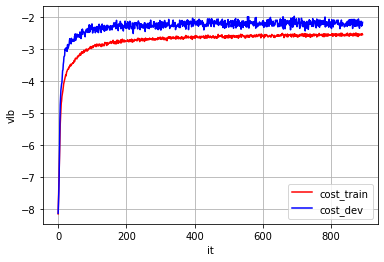

In [14]:
plt.figure()
plt.plot(np.clip(vlb_train[:curr_epoch], -1000, 1000), 'r')
plt.plot(np.clip(vlb_val[:curr_epoch], -1000, 1000), 'b')
plt.legend(['cost_train', 'cost_dev'])
plt.ylabel('vlb')
plt.xlabel('it')
plt.grid(True)
plt.savefig('./tf_vlb_plots/' +  str(dname) + '.png')

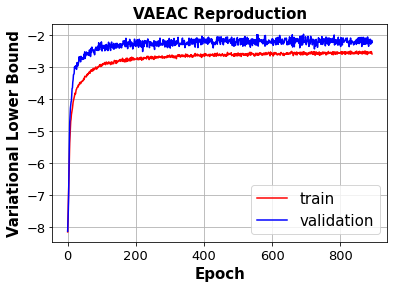

In [33]:
vlb_train = np.load('./COMPAS_Valter_VAEAC/compas_vlb_train_lr_0.0001.npy')
vlb_val = np.load('./COMPAS_Valter_VAEAC/compas_vlb_val_lr_0.0001.npy')

# best_epoch = 693 (pos 692 in train_val)
curr_epoch = 894

plt.figure()
plt.plot(np.clip(vlb_train[:curr_epoch], -1000, 1000), 'r')
plt.plot(np.clip(vlb_val[:curr_epoch], -1000, 1000), 'b')
plt.legend(['train', 'validation'], fontsize =15)
plt.ylabel('Variational Lower Bound', fontweight='bold', fontsize =15)
plt.xlabel('Epoch', fontweight='bold', fontsize =15)
plt.yticks(fontsize = 13)
plt.xticks(fontsize=13)
plt.title('VAEAC Reproduction', fontweight='bold', fontsize= 15)
plt.grid(True)
plt.savefig('./COMPAS_Valter_VAEAC/' +  'compas_vaeac' + '.png', bbox_inches="tight")

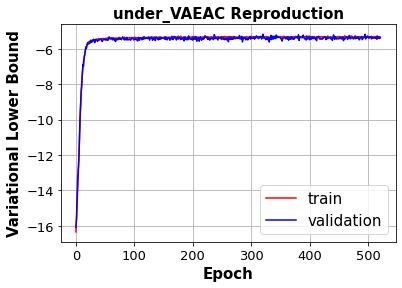

In [35]:
vlb_train = np.load('./COMPAS_Valter_under_VAEAC/compas_under_vlb_train_lr_0.0001.npy')
vlb_val = np.load('./COMPAS_Valter_under_VAEAC/compas_under_vlb_val_lr_0.0001.npy')

# best_epoch = 321 (pos 320 in train_val)
curr_epoch = 522

plt.figure()
plt.plot(np.clip(vlb_train[:curr_epoch], -1000, 1000), 'r')
plt.plot(np.clip(vlb_val[:curr_epoch], -1000, 1000), 'b')
plt.legend(['train', 'validation'], fontsize =15)
plt.ylabel('Variational Lower Bound', fontweight='bold', fontsize =15)
plt.xlabel('Epoch', fontweight='bold', fontsize =15)
plt.yticks(fontsize = 13)
plt.xticks(fontsize=13)
plt.title('under_VAEAC Reproduction', fontweight='bold', fontsize= 15)
plt.grid(True)
plt.savefig('./COMPAS_Valter_under_VAEAC/' +  'compas_under_vaeac' + '.png', bbox_inches="tight")

## Train VAEAC (default credit)

In [13]:
"""
batch_size = 64
nb_epochs = 2000 # 2000
early_stop = 200
lr = 7e-4        # Maybe this should be 1e-4, but it makes the performance terrible...

optimizer = tfa.optimizers.RectifiedAdam(lr = lr, epsilon = 1e-8)

width = 350
depth = 3
latent_dim = 8
num_examples_to_generate = 16

masker = top_masker_tensorflow(p=1)

x_train, x_test, x_means, x_stds = \
load_UCI(dset_name=dname, splits=10, seed=42, separate_targets=False, save_dir='../data/') # np.arrays

model = VAEAC_gauss_cat(width, depth, latent_dim, input_dim_vec, batch_size, lr, optimizer, save_model = True)

x_train = unnormalise_cat_vars(x_train, x_means, x_stds, input_dim_vec) # np.array
x_test = unnormalise_cat_vars(x_test, x_means, x_stds, input_dim_vec) 

vlb_train, vlb_val, best_epoch, best_vlb, curr_epoch = train_VAEAC(model, x_train, x_test, masker, nb_epochs, early_stop=early_stop, flatten = True)
"""

/opt/anaconda3/envs/py38/lib/python3.8/site-packages/tensorflow_addons/optimizers/rectified_adam.py:120: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
2021-12-11 09:16:23.922815: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


ValueError: in user code:

    File "/var/folders/38/m6rs_5bd7zsf3gjy2hg8y57r0000gn/T/ipykernel_31061/2988879061.py", line 202, in train_step_VAEAC  *
        loss, vlb, kl_divergence, rec_loss, regularizer = compute_loss_VAEAC(model, x_batch, x_flat, x_masked, mask)
    File "/var/folders/38/m6rs_5bd7zsf3gjy2hg8y57r0000gn/T/ipykernel_31061/2988879061.py", line 151, in compute_loss_VAEAC  *
        prior_params = model.prior_encoder(x_masked)
    File "/opt/anaconda3/envs/py38/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 67, in error_handler  **
        raise e.with_traceback(filtered_tb) from None
    File "/opt/anaconda3/envs/py38/lib/python3.8/site-packages/keras/engine/input_spec.py", line 263, in assert_input_compatibility
        raise ValueError(f'Input {input_index} of layer "{layer_name}" is '

    ValueError: Input 0 of layer "prior_encoder_model" is incompatible with the layer: expected shape=(None, 62), found shape=(64, 48)


## Loading model

In [ ]:
# To check the total number of trainable variables 
"""
total_parameters = 0
for variable in model.trainable_variables:
    # shape is an array of tf.Dimension
    shape = variable.get_shape()
    #print(shape)
    #print(len(shape))
    variable_parameters = 1
    for dim in shape:
        #print(dim)
        variable_parameters *= dim
    #print(variable_parameters)
    total_parameters += variable_parameters
print(total_parameters)

time.sleep(10)
"""

## Generate sample parameters

## UNDER VAEAC

In [13]:
class under_VAEAC(tf.keras.Model):
    def __init__(self, base_VAE, width, depth, latent_dim, batch_size, lr, optimizer, save_model = True):
        super(under_VAEAC, self).__init__()
        
        self.base_VAEAC = base_VAE
        self.input_dim = self.base_VAEAC.latent_dim # 8 for default credit
        self.width = width
        self.depth = depth
        self.latent_dim = latent_dim # 6 for default credit
        self.lr = lr
        
        self.prior_encoder = tfd.Normal(loc=tf.zeros(latent_dim), scale=tf.ones(latent_dim))
        
        # self.input_dim is put in a list to make sum(input_dim_vec in recognition_encoder work)
        self.recognition_encoder = create_recognition_encoder(width, depth, latent_dim, [self.input_dim])
        self.decoder = create_decoder(width, depth, latent_dim, [self.input_dim])
        
        self.vlb_scale = 1 / self.input_dim
        self.batch_size = batch_size
        self.optimizer = optimizer
        self.save_model = save_model

    # Inspiration taken from 
    # https://github.com/joocxi/tf2-VAEAC/blob/d2b1bbc258ec77ee0975ea7eb68e63c4efcda6f0/model/vaeac.py

    def reconstruction_loss(self, x, y):
        log_prob_vec = []
        reshape_dim = self.batch_size
        for idx in range(self.input_dim):
            # Gaussian_case
            
            # minus sign in front because vlb on return after calling this adds it
            log_prob_vec.append(tf.expand_dims(-(x[:, idx] - y[:, idx])**2, 1))

        log_prob_vec = tf.reshape(log_prob_vec, [reshape_dim, self.input_dim])
        log_prob_vec = tf.math.reduce_sum(log_prob_vec, axis= -1)
        
        return log_prob_vec
    
def compute_loss_under_VAEAC(model, x_flat, proposal_params_VAEAC):
    
    # Essentially CLUEs normal_parse_params
    proposal_distribution_VAEAC = tfd.Normal(
      loc=proposal_params_VAEAC[..., :model.input_dim],
      scale=tf.clip_by_value(
        tf.nn.softplus(proposal_params_VAEAC[..., model.input_dim:]),
        1e-3,
        tf.float32.max),
      name="proposal")
    
    z_sample = proposal_distribution_VAEAC.sample() # tensor with dim (base_VAEAC.latent_dim,)
    
    proposal_params_VAE = model.recognition_encoder(z_sample) 

    proposal_distribution_VAE = tfd.Normal(
      loc=proposal_params_VAE[..., :model.latent_dim],
      scale=tf.clip_by_value(
        tf.nn.softplus(proposal_params_VAE[..., model.latent_dim:]),
        1e-3,
        tf.float32.max),
      name="priors")

    u_sample = proposal_distribution_VAE.sample() 
    
    rec_params = model.decoder(u_sample) 
    
    # True distribution, Estimated distribution in this order
    kl_divergence = tf.reduce_sum(
      tf.reshape(
        tfd.kl_divergence(proposal_distribution_VAE, model.prior_encoder),
        (model.batch_size, -1)), -1)
    
    rec_loss = model.reconstruction_loss(rec_params, z_sample)
    
    vlb = tf.reduce_mean(-kl_divergence + rec_loss) # For comparing
    loss = tf.reduce_mean((kl_divergence - rec_loss) * model.vlb_scale) 
    return loss, vlb, kl_divergence, rec_loss

@tf.function # Converts all numpy arrays to tensors
def train_step_under_VAEAC(model, x_flat, proposal_params_VAEAC):

    with tf.GradientTape() as tape:
        loss, vlb, kl_divergence, rec_loss = compute_loss_under_VAEAC(model, x_flat, proposal_params_VAEAC)
    
    gradients = tape.gradient(loss, model.trainable_variables)
    model.optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss, vlb, kl_divergence, rec_loss

In [14]:
def batch(iterable, n=1):
    l = len(iterable)
    for ndx in range(0, l, n):
        yield iterable[ndx:min(ndx + n, l)]

def train_VAE(model, x_train, x_test, nb_epochs, early_stop = None, flatten = False):
    
    vlb_train = np.zeros(nb_epochs)
    vlb_val = np.zeros(nb_epochs)
    best_vlb = -np.inf
    best_epoch = 0
    
    overall_batch_size = model.batch_size
    
    test_data = []
    for x in batch(x_test, n = overall_batch_size):
        test_data.append(x)
    
    epoch = 0
    for epoch in range(0, nb_epochs):
        tic = time.time()
        
        train_data = []
        np.random.shuffle(x_train)
        for x in batch(x_train, n = overall_batch_size):
            train_data.append(x)
        
        ## Training
        nb_samples = 0
        for x_batch in train_data:

            model.batch_size = x_batch.shape[0] # TODO: FIX THIS: Very ugly solution now to make sure batches 
                                                # that do not have the full size
            
            # If data is not already flattened (default credit)
            if flatten:
                x_batch_flat = gauss_cat_to_flat(x_batch, model.input_dim_vec) # numpy
            # If data is already flattened (COMPAS from join_compas_targets)
            else:
                x_batch_flat = x_batch
            
            x_batch_flat = tf.convert_to_tensor(x_batch_flat)
    
            proposal_params_VAEAC = model.base_VAEAC.recognition_encoder(x_batch_flat) # tensor with dim (16,)
            
            loss, vlb, kl_divergence, rec_loss = train_step_under_VAEAC(model, x_batch_flat, proposal_params_VAEAC)

            vlb_train[epoch] += vlb.numpy() * x_batch.shape[0]
            nb_samples += x_batch.shape[0]

        vlb_train[epoch] /= nb_samples
        toc = time.time()
        print("Epoch" + str(epoch) + ", vlb: " + str(vlb_train[epoch]) + ", took: " + str(toc-tic))
        
        ## Validation
        nb_samples = 0
        
        for x_batch in test_data:
            model.batch_size = x_batch.shape[0] # TODO: FIX THIS: Very ugly solution now to make sure batches 
                                                # that do not have the full size
            
            # If data is not already flattened (default credit)
            if flatten:
                x_batch_flat = gauss_cat_to_flat(x_batch, model.input_dim_vec) # numpy
            # If data is already flattened (COMPAS from get_my_COMPAS)
            else:
                x_batch_flat = x_batch
            
            x_batch_flat = tf.convert_to_tensor(x_batch_flat)
    
            proposal_params_VAEAC = model.base_VAEAC.recognition_encoder(x_batch_flat) # tensor with dim (16,)
            
            # In CLUE there is actually no difference between eval and fitother than that we should not update the weights.
            # Therefore ok to just call compute_loss_under_VAEAC directly instead of a special eval func
            loss, vlb, kl_divergence, rec_loss = compute_loss_under_VAEAC(model, x_batch_flat, proposal_params_VAEAC)

            vlb_val[epoch] += vlb.numpy() * x_batch.shape[0]
            nb_samples += x_batch.shape[0]

        vlb_val[epoch] /= nb_samples

        if vlb_val[epoch] > best_vlb:
            best_vlb = vlb_val[epoch]
            best_epoch = epoch
            if(model.save_model):
                #open text file
                text_file = open("./COMPAS_Valter_under_VAEAC/" + str(dname) + "_best_epoch_under_VAEAC_lr_" + str(model.lr) + ".txt", "w")

                #write string to file
                text_file.write(str(epoch))

                #close file
                text_file.close()

                model.recognition_encoder.save("./COMPAS_Valter_under_VAEAC/" + str(dname) + "_under_recog_encoder_lr_" + str(model.lr))
                model.decoder.save("./COMPAS_Valter_under_VAEAC/" + str(dname) + "_under_decoder_lr_" + str(model.lr))

        print("Validation vlb: " + str(vlb_val[epoch]) + ", Best vlb: " + str(best_vlb) + "\n")

        if early_stop is not None and (epoch - best_epoch) > early_stop:
            print("Early stopping triggered")
            break
    
    np.save("./COMPAS_Valter_under_VAEAC/" + str(dname) + "_under_vlb_train_lr_" + str(model.lr), vlb_train)
    np.save("./COMPAS_Valter_under_VAEAC/" + str(dname) + "_under_vlb_val_lr_" + str(model.lr), vlb_val)
    return vlb_train, vlb_val, best_epoch, best_vlb, epoch




In [15]:
dname = 'compas'
print(dname)

input_dim_vec = [3, 6, 2, 2, 2, 1, 1, 2]
batch_size = 128
nb_epochs = 2000
early_stop = 200
lr = 1e-4
width = widths[names.index(dname)] # 350
depth = depths[names.index(dname)] # number of hidden layers # 3
latent_dim = latent_dims[names.index(dname)] # 4

x_train, x_test, x_means, x_stds, y_train, y_test, feature_names, X_dims = \
    get_my_COMPAS(rseed=42, separate_test=True, test_ratio=0.1, save_dir='../data/')

x_train, x_test, input_dim_vec = join_compas_targets(x_train, x_test, y_train, y_test, X_dims)

print('Compas', x_train.shape, x_test.shape)
print(input_dim_vec)
#"""

optimizer_VAEAC = tfa.optimizers.RectifiedAdam(lr = lr, epsilon = 1e-8)

# Create new model to load in weightsinto that can then continued to be trained
model2 = VAEAC_gauss_cat(width, depth, latent_dim, input_dim_vec, batch_size, lr, optimizer_VAEAC, save_model = False)

model2.recognition_encoder = keras.models.load_model("./Valter_VAEAC/compas_recog_encoder_lr_0.0001")
model2.prior_encoder = keras.models.load_model("./Valter_VAEAC/compas_prior_encoder_lr_0.0001")
model2.decoder = keras.models.load_model("./Valter_VAEAC/compas_decoder_lr_0.0001")


# No mask is used to train the 2nd lvl VAE
#masker = top_masker_tensorflow(p=1)

base_network = model2
width = 150
depth = 2
latent_dim = under_latent_dims[names.index(dname)]

batch_size = 128
nb_epochs = 2000
early_stop = 200
lr = 1e-4

optimizer_under_VAEAC = tf.keras.optimizers.Adam(lr = lr, epsilon = 1e-8)
#optimizer_under_VAEAC = tfa.optimizers.RectifiedAdam(lr = lr, epsilon = 1e-8)

under_VAEAC_net = under_VAEAC(base_network, width, depth, latent_dim, batch_size, lr, \
                              optimizer_under_VAEAC, save_model = False)

vlb_train, vlb_val, best_epoch, best_vlb, curr_epoch = train_VAE(under_VAEAC_net, x_train, x_test, nb_epochs, early_stop=early_stop)



compas
Compas (5554, 19) (618, 19)
[3 6 2 2 2 1 1 2]


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/tensorflow_addons/optimizers/rectified_adam.py:120: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
2021-12-13 13:01:46.043092: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/opt/anaconda3/envs/py38/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
2021-12-13 13:01:49.368327: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


Epoch0, vlb: -13.974108723800818, took: 3.0440380573272705
Validation vlb: -12.603024263598, Best vlb: -12.603024263598

Epoch1, vlb: -11.512968399905025, took: 0.6395220756530762
Validation vlb: -10.185881068405596, Best vlb: -10.185881068405596

Epoch2, vlb: -9.447635804829856, took: 0.7047171592712402
Validation vlb: -8.717284005050907, Best vlb: -8.717284005050907

Epoch3, vlb: -8.138348224826712, took: 0.6325180530548096
Validation vlb: -7.9152032318238685, Best vlb: -7.9152032318238685

Epoch4, vlb: -7.414419886960286, took: 0.6474659442901611
Validation vlb: -7.173444448551313, Best vlb: -7.173444448551313

Epoch5, vlb: -6.917978245532895, took: 0.6393449306488037
Validation vlb: -6.869564449902877, Best vlb: -6.869564449902877

Epoch6, vlb: -6.5417620207622065, took: 0.6579139232635498
Validation vlb: -6.268019654604224, Best vlb: -6.268019654604224

Epoch7, vlb: -6.127180304851813, took: 0.5743939876556396
Validation vlb: -5.999173869592858, Best vlb: -5.999173869592858

Epoch

Epoch66, vlb: -5.434958294479376, took: 0.5572819709777832
Validation vlb: -5.551028186835132, Best vlb: -5.3734168543398955

Epoch67, vlb: -5.410896418203671, took: 0.5435190200805664
Validation vlb: -5.364662849401579, Best vlb: -5.364662849401579

Epoch68, vlb: -5.436508031555934, took: 0.5518178939819336
Validation vlb: -5.528605609264188, Best vlb: -5.364662849401579

Epoch69, vlb: -5.406671770279211, took: 0.5562231540679932
Validation vlb: -5.420719861212672, Best vlb: -5.364662849401579

Epoch70, vlb: -5.427052634887915, took: 0.5579991340637207
Validation vlb: -5.486631640338589, Best vlb: -5.364662849401579

Epoch71, vlb: -5.421849726428649, took: 0.5449390411376953
Validation vlb: -5.481140161409347, Best vlb: -5.364662849401579

Epoch72, vlb: -5.370235202893706, took: 0.5438971519470215
Validation vlb: -5.3987418995706005, Best vlb: -5.364662849401579

Epoch73, vlb: -5.402454812706139, took: 0.6013917922973633
Validation vlb: -5.425106293946794, Best vlb: -5.364662849401579

KeyboardInterrupt: 

In [ ]:
print("best_vlb: ", best_vlb)
print("best epoch: ", best_epoch)
plt.figure()
plt.plot(np.clip(vlb_train[:curr_epoch], -1000, 1000), 'r')
plt.plot(np.clip(vlb_val[:curr_epoch], -1000, 1000), 'b')
plt.legend(['cost_train', 'cost_dev'])
plt.ylabel('vlb')
plt.xlabel('it')
plt.grid(True)
plt.savefig( str(dname) + '_vlb_lr_' + str(model.lr) + '.png')

In [ ]:
# For Default credit
"""
input_dim_vec = [1, 2, 4, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1 ,1 ,1 ,1 ,1 ,1, 2]
width = 350
depth = 3
latent_dim = 8
num_examples_to_generate = 16

batch_size = 128
nb_epochs = 2000 # 2000
early_stop = 200
lr = 1e-4        # Maybe this should be 1e-4, but it makes the performance terrible...

x_train, x_test, x_means, x_stds = \
load_UCI(dset_name=dname, splits=10, seed=42, separate_targets=False, save_dir='../data/') # np.arrays

x_train = unnormalise_cat_vars(x_train, x_means, x_stds, input_dim_vec) # np.array
x_test = unnormalise_cat_vars(x_test, x_means, x_stds, input_dim_vec) 
"""

# For COMPAS
#"""
dname = 'compas'
print(dname)

input_dim_vec = [3, 6, 2, 2, 2, 1, 1, 2]
batch_size = 128
nb_epochs = 2000
early_stop = 200
lr = 1e-4
width = widths[names.index(dname)] # 350
depth = depths[names.index(dname)] # number of hidden layers # 3
latent_dim = latent_dims[names.index(dname)] # 4

x_train, x_test, x_means, x_stds, y_train, y_test, feature_names, X_dims = \
    get_my_COMPAS(rseed=42, separate_test=True, test_ratio=0.1, save_dir='../data/')

x_train, x_test, input_dim_vec = join_compas_targets(x_train, x_test, y_train, y_test, X_dims)

print('Compas', x_train.shape, x_test.shape)
print(input_dim_vec)
#"""

optimizer_VAEAC = tfa.optimizers.RectifiedAdam(lr= lr , epsilon=1e-8)

# Create new model to load in weightsinto that can then continued to be trained
model2 = VAEAC_gauss_cat(width, depth, latent_dim, input_dim_vec, batch_size, lr, optimizer_VAEAC, save_model = False)

model2.recognition_encoder = keras.models.load_model("./Valter_VAEAC/compas_recog_encoder_lr_0.0001")
model2.prior_encoder = keras.models.load_model("./Valter_VAEAC/compas_prior_encoder_lr_0.0001")
model2.decoder = keras.models.load_model("./Valter_VAEAC/compas_decoder_lr_0.0001")


# No mask is used to train the 2nd lvl VAE
#masker = top_masker_tensorflow(p=1)

base_network = model2
width = 150
depth = 2
latent_dim = under_latent_dims[names.index(dname)]

batch_size = 128
nb_epochs = 2000
early_stop = 200
lr = 1e-4

optimizer_under_VAEAC = tfa.optimizers.RectifiedAdam(lr = lr, epsilon = 1e-8)

under_VAEAC_net = under_VAEAC(base_network, width, depth, latent_dim, batch_size, lr, \
                              optimizer_under_VAEAC, save_model = False)

vlb_train, vlb_val, best_epoch, best_vlb, curr_epoch = train_VAE(under_VAEAC_net, x_train, x_test, nb_epochs, early_stop=early_stop)



In [19]:
print("best_vlb: ", best_vlb)
print("best epoch: ", best_epoch)

best_vlb:  -5.184708448675458
best epoch:  320


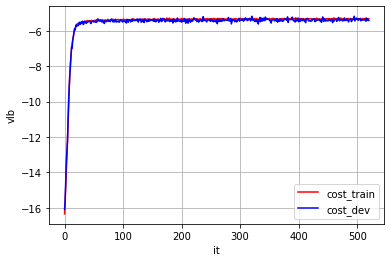

In [21]:
print("best_vlb: ", best_vlb)
print("best epoch: ", best_epoch)
plt.figure()
plt.plot(np.clip(vlb_train[:curr_epoch], -1000, 1000), 'r')
plt.plot(np.clip(vlb_val[:curr_epoch], -1000, 1000), 'b')
plt.legend(['cost_train', 'cost_dev'])
plt.ylabel('vlb')
plt.xlabel('it')
plt.grid(True)
plt.savefig( str(dname) + '_vlb_lr_' + str(model.lr) + '.png')

In [16]:
#"""
total_parameters = 0
for variable in under_VAEAC_net.trainable_variables:
    # shape is an array of tf.Dimension
    shape = variable.get_shape()
    #print(shape)
    #print(len(shape))
    variable_parameters = 1
    for dim in shape:
        #print(dim)
        variable_parameters *= dim
    #print(variable_parameters)
    total_parameters += variable_parameters
print(total_parameters)

#"""

827897


In [5]:
import numpy as np
print(np.load("./COMPAS_VAEAC/compas_vlb_train_lr_0.0001.npy"))

[-6.73977529 -5.61497819 -4.62562061 ...  0.          0.
  0.        ]


In [18]:
#print(under_VAEAC_net.trainable_variables)

In [19]:
#print(model2.decoder.summary())

In [26]:
# TO check the that the parameters in the VAEAC are not trained during the training of under_VAEAC

# Encoder
#print(model2.recognition_encoder.trainable_variables[0])

# Decoder
#print(model2.decoder.trainable_variables[0])

In [27]:
# Encoder
"""
model2 = VAEAC_gauss_cat(width, depth, latent_dim, input_dim_vec, batch_size, lr, optimizer_VAEAC, save_model = True)
model2.recognition_encoder = keras.models.load_model("./COMPAS_VAEAC/compas_recog_encoder_lr_0.0001")
print(model2.recognition_encoder.trainable_variables[0])
"""

# Decoder
"""
model2 = VAEAC_gauss_cat(width, depth, latent_dim, input_dim_vec, batch_size, lr, optimizer_VAEAC, save_model = True)

model2.decoder = keras.models.load_model("./COMPAS_VAEAC/compas_decoder_lr_0.0001")

print(model2.decoder.trainable_variables[0])
"""


'\nmodel2 = VAEAC_gauss_cat(width, depth, latent_dim, input_dim_vec, batch_size, lr, optimizer_VAEAC, save_model = True)\n\nmodel2.decoder = keras.models.load_model("./COMPAS_VAEAC/compas_decoder_lr_0.0001")\n\nprint(model2.decoder.trainable_variables[0])\n'

In [22]:
#print(model2.prior_encoder.summary())

In [23]:
#print(under_VAEAC_net.decoder.summary())

In [24]:
#print(under_VAEAC_net.recognition_encoder.summary())

In [ ]:
### Currently Working on ###

### TODO ###

# Make code work for only continous data (GaussianLogLike?)

# Train VAEAC (default credit) using 7e-4 lr and save the model

# Clean up the code

## eval/training mode things ##

# Verify if BatchNorm does what it should when training = True/False is not sent into the model

# Do I need to set the models to eval mode and not training during validation data or does tf handle this?
    # Apparently batchnorm layers do different things during training/evaluation
    # Adding training = True affects a lot..., it is not enabled by default during train_step gradient.
    # Setting training = True in eval affects the training_VAE still. 
    # Not using training = True/False makes the model work well, 
    # Question is if BatchNorm does the correct thing during eval

##---------------------------##


## Ask Ali 
    # If His network has the correct structure (The decoder was wrong for VAEAC)
    # If He has thought of initlialisations
    # hyperparameters, bias, epsilon, momentum etc.
    # Where are the batches?

# Skip connections from prior to decoder? I don't think CLUE got this to work properly...
    # Memory layer is used in Tf2 github

# Not sure what the TF equivalence of affine and track_running_stats is in Torch BatchNorm1D 
    
# Why does train_step only print things inside it twice for the first batch and then never for any other batch?
    
### TO IMPLEMENT ###


### DONE ###
"""

√ under_VAEAC updates the VAEAC recognition_encoder parameters. Need to freeze them somehow...
    # Maybe calculate proposal_params_VAEAC before calling train_step_under_VAEAC to make it work?
    # Yup, that did the trick

√ Something wrong with the number of trainable parameters in my under_VAEAC? Seems to be way more than in Torch?
    # The VAEAC recognition_encoder was being trained in under_VAEAC

√ Make VAEAC work for COMPAS
    # How to load COMPAS?

√ Train the VAEAC for COMPAS

√ Fix the under_VAEAC code  (i.e. get eval to work there just as in VAEAC)

√ update_train VAE with the train_VAEAC code (Add Shuffle among many things)

√ Plot the loss graph over train and validation set

√ Save the vlb_train & vlb_val after training

√ rec_los: Should the target not be flattened but instead just x_batch?
    # Don't think so, the final values look fairly similar.
    # I think it is fine since the program seems to be doing what it should

√ How do the batches work in the network? How can we send a 64x31 batch to encoder? It should only take 31 as input
    # the keras.input((31, )) means it expect features with dimension 31 and unspecified batch_size. 
    # When a batch with 64,31 size comes it in will treat each row as a sample

√ Should I have 7e-4 or 1e-4 learning rate?
    # 7e-4 for comparing and making sure the model works as intended but 1e-4 for the real training

√ Remove reparametrize?

√ Add lr to print epoch in VAEAC training

√ Is something wrong with the trainable variables? Should I before training use tf.Variable to make them trainable?
    # https://www.tensorflow.org/api_docs/python/tf/Variable
    # Seems right, it is the exact same amount of trainable parameters in torch and tf

√ Have I forgotten to do a tf.reduce_sum over regularisation? 
    # Don't think so... their sum(-1) on reg_cost does nothing

√ Something might be wrong with how the training is done with batches... 
    # Probably not, input(shape,) makes it so that it expects one dimension to be of shape 
    # without specifying the batch size

√ vlb_val is calculated using eval not fit

√ Add shuffling of the training data 

√ Verify the number of trainable parameters in CLUE vs TF 
    # Exact same amount for under_VAEAC and VAEAC

√ implement under_VAEAC vlb (MSELoss and KL-divergence)

√ rsample instead of sample? (rsample for derivatives in torch, tf does not care)

√ Save the model during training (best vlb)

√ Fix so that training with 2nd lvl VAE is done without the mask

√ 1e-4 can at times get very poor vlb at the start but then recover. Why is this?   
    # Seems to have been solved by initialising the dense weights and bias weights the same way as Torch
    # I get like -19 or -20, -22 every single first epoch now

√ Validation vlb not low enough? 
    # Not terrible but indeed not as low, seems to go towards the right values at least but it happens slowly

√ Need to initialise the weights in keras dense for the neurons and bias the same way as nn.linear

√ Need to make the layers in a skip connection sequential? nn.sequential in torch
    # The russian doll effect does exactly this!
    
√ What activation is used in dense/nn.linear?
    # None
    
√ Is keras dense and torch nn.linear the same thing?
    # How are the weights inited in each? (Different ways by default but I made them init the same way)
    # They are basically the same, input to neural network nodes (bias = True add a bias node)
    # Google images for keras dense and nn.linear and you see that it is just a normal feed forward process.
"""